In [246]:
%reload_ext autoreload
%autoreload 2

import ast
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import helpers


sns.set_theme()

In [173]:
movies, characters = helpers.import_movies_data("./data/")
# NOTE: drop entry if either side is missing 
# NOTE: a movie has multiple actors and thus multiple rows
df_by_actors = pd.merge(movies, characters, how='inner', on=['wikipedia_movie_ID'])

print(df_by_actors.shape)

/Users/chuck/IdeaProjects/ada-2023-project-zalix/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


(106354, 25)


In [174]:
# NOTE: drop data after 2009 (incomplete in decade 2010s - only up to 2013)
df_by_actors = df_by_actors[df_by_actors['year_released'] <= 2009]

# add decade column
df_by_actors['decade'] = df_by_actors['year_released'].apply(lambda x: int(x/10)*10)

# rename rating column
df_by_actors = df_by_actors.rename(columns={'averageRating': 'imdb_rating'})

In [175]:
# create a data frame of unique films 
df_by_films = df_by_actors.drop_duplicates(subset=['wikipedia_movie_ID']).reset_index().set_index('wikipedia_movie_ID').copy()

In [176]:
# compute # cast ethnicities per film
# NOTE: ignore missing values in ethnicity columns 
# NOTE: fill NaN with 1 after tallying 
n_ethnicities_per_film = df_by_actors.groupby(['wikipedia_movie_ID'])['actor_ethnicity'].nunique().replace(0, 1)

# add # cast ethnicities column
df_by_films['num_ethnicities'] = n_ethnicities_per_film

<Axes: xlabel='num_ethnicities', ylabel='Proportion'>

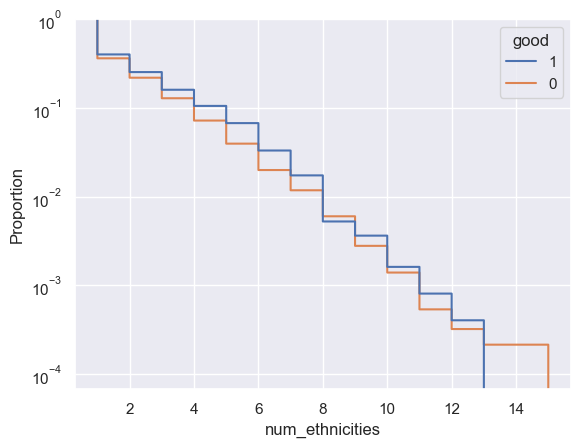

In [177]:
# 1. distribution of # cast ethnicities among good vs non-good films => show ethnic diversity as a potentially interesting factor in film rating


# plot CDF of # cast ethnicities ~ proportion between good vs non-good films
df_by_films['good'] = df_by_films['imdb_rating'] >= 7.0
# NOTE: close curves but good films curve almost always above (greater proportion > x) non-good => good films have greater ethnic diversity in cast in general 
sns.ecdfplot(data=df_by_films, x="num_ethnicities", hue="good", hue_order=[1, 0], complementary=True, log_scale=[False, True])
# TODO: edit legend: good vs non-good films
# TODO: add title


// TODO: add interpretation

/Users/chuck/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


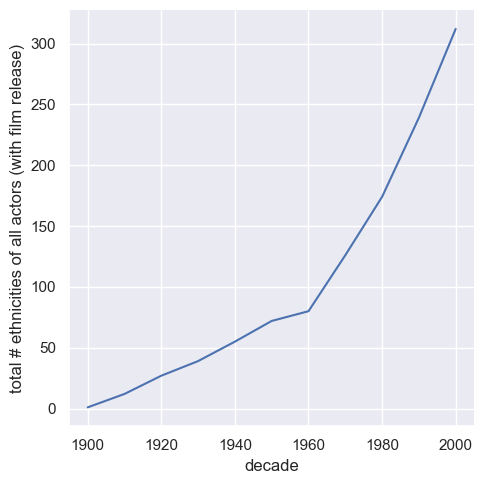

In [178]:
# 2. ethnic demographic change among actors (# actor ethnicities) over time AND ethnic diversity change among cast/on-screen (# cast ethnicities) over time 


# compute # distinct ethnicities among actors for each decade
# NOTE: ignore missing values in ethnicity column
n_actor_ethnicities_by_decade = pd.crosstab(df_by_actors['decade'], df_by_actors['actor_ethnicity']).apply(lambda x: (x != 0).sum(), axis=1)

# plot decade ~ # distinct actor ethnicities across all films
g = sns.relplot(n_actor_ethnicities_by_decade, kind='line')
g.set_ylabels('total # ethnicities of all actors (with film release)')

/Users/chuck/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


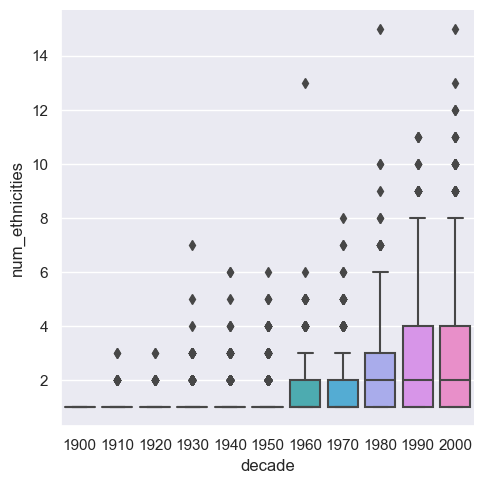

In [179]:
# plot decade ~ (distribution) # actor ethnicities per film
# NOTE: # ethnicities among cast follows power law distribution => use robust statistics
g = sns.catplot(df_by_films, x='decade', y='num_ethnicities', kind='box', hue_order=[1, 0])
# g.set_ylabels('# ethnicities among actors per film')

// TODO: interpretations

/Users/chuck/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


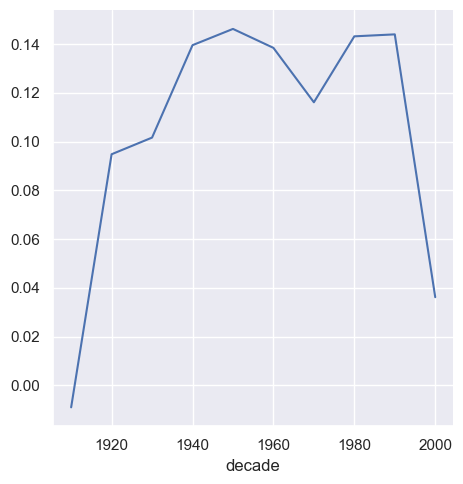

In [180]:
# 3. correlation between cast’s ethnic diversity and film rating over time 


# compute the correlation coefficient of # cast ethnicities and film rating for each decade
cor_by_decade = df_by_films.groupby('decade').apply(lambda x: x['num_ethnicities'].corr(x['imdb_rating']))

# plot decade ~ # cast ethnicities and film rating correlation coefficient
sns.relplot(data=cor_by_decade, kind='line')


TODO: interpretation

0.22720313031643416


/Users/chuck/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


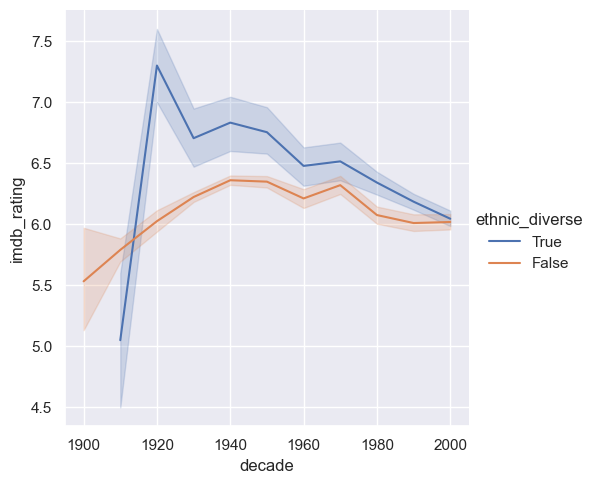

In [271]:
# 4. average rating of ethnically diverse films vs ethnically non-diverse films 


# plot decade ~ avg rating of ethnically diverse films (treated) vs ethnically non-diverse films (control)
df_by_films['ethnic_diverse'] = df_by_films['num_ethnicities'] >= 3
print(df_by_films['ethnic_diverse'].sum() / df_by_films.shape[0])
# NOTE: error bar = 95% confidence interval
sns.relplot(df_by_films, x='decade', y='imdb_rating', hue='ethnic_diverse', kind='line', hue_order=[True, False])

TODO: interpretation

In [182]:
# build regression model for propensity matching on ethnic diversity


# feature selection
# use observed covariates: movie_release_date, movie_languages, movie_countries, movie_genres
df_reg = df_by_films[['movie_release_date', 'movie_languages', 'movie_countries', 'movie_genres', 'ethnic_diverse', 'decade']].copy()

# data preprocessing
# handle missing values: drop rows
df_reg = df_reg.replace('{}', np.nan)

print(df_reg.isna().sum(axis=0) / df_reg.shape[0])

old_shape = df_reg.shape
df_reg = df_reg.dropna()
# NOTE: dropped 7.5% rows
print(old_shape, df_reg.shape, df_reg.shape[0] / old_shape[0])


movie_release_date    0.000000
movie_languages       0.060225
movie_countries       0.026625
movie_genres          0.005614
ethnic_diverse        0.000000
decade                0.000000
dtype: float64
(11756, 6) (10877, 6) 0.9252296699557673


In [183]:
# feature encoding
# split movie_release_date to year, month, day & standardize
release = pd.to_datetime(df_reg['movie_release_date'])
release_date = pd.DataFrame({'year': release.dt.year, 'month': release.dt.month, 'day': release.dt.day})
release_date_std = StandardScaler().fit_transform(release_date)

# extract movie_languages values & one-hot encode
languages = df_reg['movie_languages'].apply(lambda x: list(ast.literal_eval(x).values()))
languages_encoded = languages.str.join('|').str.get_dummies()

# extract movie_countries values & one-hot encode
countries = df_reg['movie_countries'].apply(lambda x: list(ast.literal_eval(x).values()))
countries_encoded = countries.str.join('|').str.get_dummies()

# extract movie_genres values & one-hot encode
genres = df_reg['movie_genres'].apply(lambda x: list(ast.literal_eval(x).values()))
genres_encoded = genres.str.join('|').str.get_dummies()


In [273]:
# model fitting 
# predict each film's probability of being ethnically diverse 
X = np.concatenate((release_date_std, languages_encoded, countries_encoded, genres_encoded), axis=1)
Y = df_reg['ethnic_diverse']
# NOTE: unbalanced dataset => class_weight=balanced
prob = LogisticRegression(random_state=12, solver='lbfgs', max_iter=1000, class_weight='balanced').fit(X, Y).predict_proba(X)[:, 1]

In [274]:
# propensity matching 

def find_matching(treated, control):
  G = nx.Graph()
  # add edges between treated and control
  for ti, t in treated.iterrows():
    for ci, c in control.iterrows():
      # match on similarity of propensity
      similarity = np.abs(t["propensity"] - c["propensity"])
      G.add_weighted_edges_from([(ti, ci, similarity)])
  # find optimal matching approximation (performance)
  return nx.approximation.min_maximal_matching(G)

def find_matching_for_decade(x):
  start = time.time()
  matching = find_matching(x[x['ethnic_diverse']], x[~x['ethnic_diverse']])
  end = time.time()
  print(f'decade: {x["decade"].iloc[0]}, time: {end - start}s')
  return matching

df_reg['propensity'] = prob
# match by each decade separately (performance)
matching_by_decade = df_reg.groupby('decade').apply(lambda x: find_matching_for_decade(x))

decade: 1900, time: 0.0038650035858154297s
decade: 1910, time: 0.024428129196166992s
decade: 1920, time: 0.028515100479125977s
decade: 1930, time: 0.526695966720581s
decade: 1940, time: 1.0533010959625244s
decade: 1950, time: 1.292773962020874s
decade: 1960, time: 1.1637539863586426s
decade: 1970, time: 1.6372387409210205s
decade: 1980, time: 5.145144939422607s
decade: 1990, time: 11.821731090545654s
decade: 2000, time: 34.319820165634155s


In [275]:
# get indices of matched films
matches = np.array([list(pair) for matching in matching_by_decade.values for pair in matching]).flatten()

print([len(matching) for matching in matching_by_decade.values])
print(len(matches))

[0, 2, 2, 21, 34, 65, 98, 143, 369, 747, 1150]
5262


In [276]:
print(matches[:2])
df_by_films.loc[matches[:2]]

[   73842 11449217]


,index,freebase_movie_ID_x,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,...,actor_name,actor_age_at_movie_release,freebase_character/actor_map_ID,freebase_character_ID,freebase_actor_ID,decade,num_ethnicities,good,ethnic_diverse,ethnic_significance
wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,,
73842,281,/m/0jsc_,Gertie the Dinosaur,1914-09-14,NaN,12.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/01hmnh"": ""Fant...",1914,...,Max Fleischer,NaN,/m/0czx1ff,NaN,/m/019r_1,1910,2,True,False,False
11449217,90011,/m/02rd16v,A Film Johnnie,1914-03-02,NaN,15.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",1914,...,Charlie Chaplin,NaN,/m/03kzg9n,NaN,/m/01lc5,1910,3,False,True,False


[   4    4   42   68  130  196  286  738 1494 2300]
decade
1910    0.960277
1920    0.147175
1930    0.048198
1940    0.000990
1950    0.015074
1960    0.002757
1970    0.126437
1980    0.000038
1990    0.001252
2000    0.290921
dtype: float64
Index([1930, 1940, 1950, 1960, 1980, 1990], dtype='int64', name='decade')


/Users/chuck/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


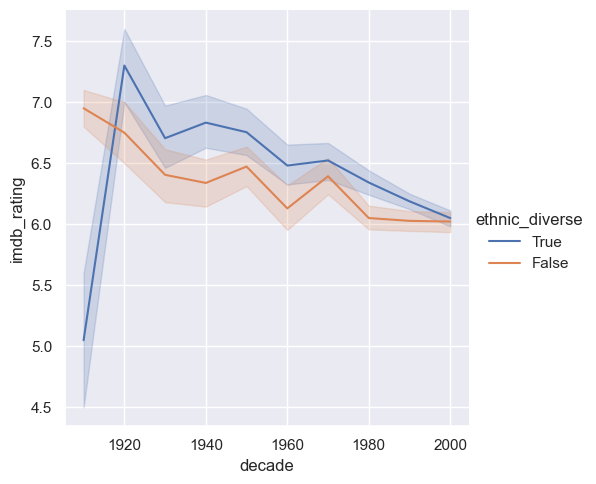

In [281]:
# 5. significance in difference in average ratings between treated and control after pair matching for each decade

# compute significance in difference in average ratings
df_matches = df_by_films.loc[matches]
p_values = df_matches.groupby('decade').apply(lambda x: stats.ttest_ind(x[x['ethnic_diverse']]['imdb_rating'], x[~x['ethnic_diverse']]['imdb_rating'], alternative='greater')[-1])
sig_decades = p_values[p_values < 0.05].index

print(df_matches.groupby('decade').size().values)
print(p_values)
print(sig_decades)

# plot decade ~ avg ratings of pair-matched ethnically diverse films (treated) vs non-ethnically diverse films (control) + significance markers 
df_matches['ethnic_significance'] = df_matches['decade'].isin(sig_decades)
# NOTE: error bar = 95% confidence interval
g = sns.relplot(df_matches, x='decade', y='imdb_rating', hue='ethnic_diverse', kind='line', hue_order=[True, False])
# TODO: add 1900 to x-axis to show lack of matched pairs
# TODO: add markers for statistically significant decades


TODO: interpretation